## Setup environment

In [3]:
# %python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
# %python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline
%pip install tqdm



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [5]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.3.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /opt/anaconda3/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.1
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencie

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [7]:
directory = os.environ.get("/Users/matt/Desktop/PROJECT/lung-tumours-segmentation-main/data")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/var/folders/2t/82y21vp92zb3ydk5bvhc55r00000gn/T/tmpp9x9ovd0


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [9]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task06_Lung.tar")
# data_dir = os.path.join(root_dir, "Task06_Lung")
data_dir = "/Users/matt/Desktop/PROJECT/lung-tumours-segmentation-main/data/Task06_Lung"
# if not os.path.exists(data_dir):
#     download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [11]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [13]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [15]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/opt/anaconda3/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

{'image': metatensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

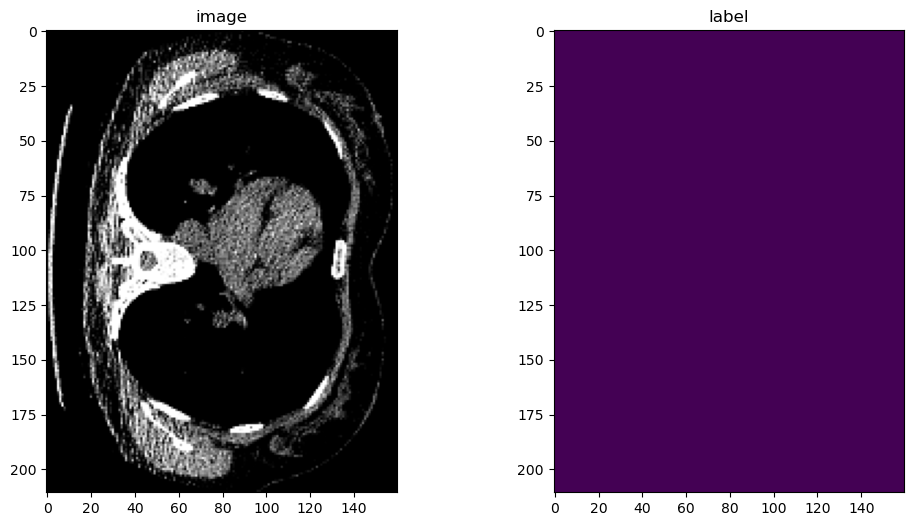

In [17]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
print(check_data)

image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

Image shape: torch.Size([211, 160, 141])
Label shape: torch.Size([211, 160, 141])


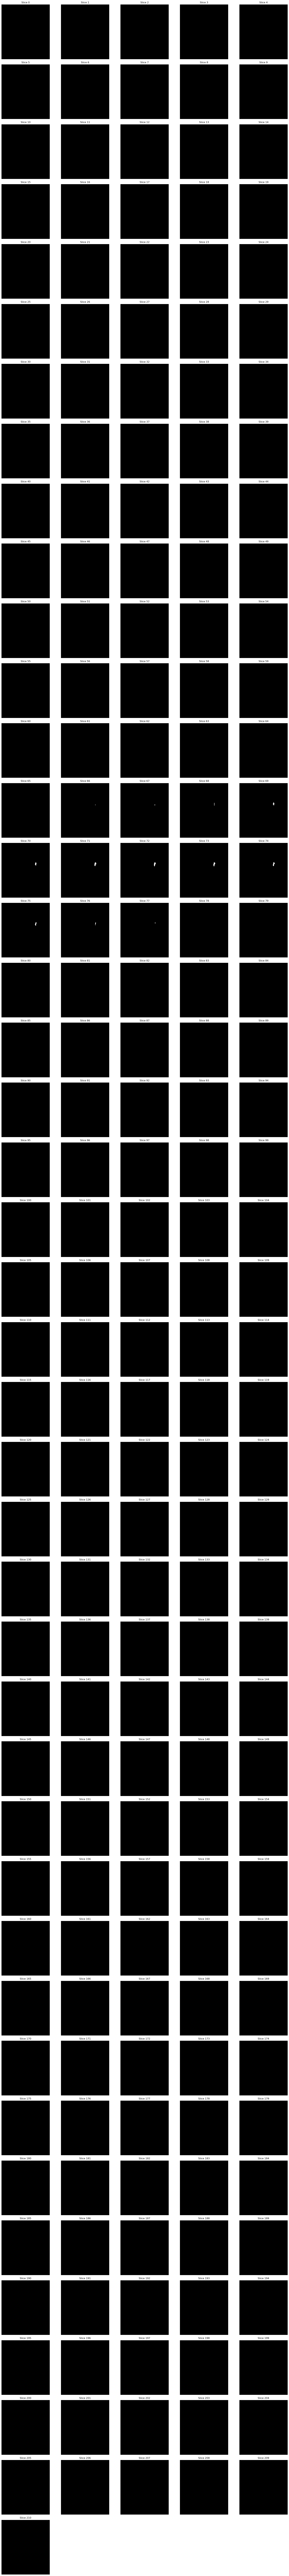

In [19]:
import torch
import matplotlib.pyplot as plt

# Assuming check_data["image"] and check_data["label"] are 5D tensors
# [batch_size, channels, depth, height, width]

# Extract the first image and its label (assuming single-channel for simplicity)
image = check_data["image"][0, 0]
label = check_data["label"][0, 0]

# Verify shapes
print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")

# Number of slices
num_slices = image.shape[0]

# Calculate the number of rows and columns for the subplots
num_cols = 5
num_rows = (num_slices + num_cols - 1) // num_cols  # Ceiling division

plt.figure(figsize=(20, 4 * num_rows))

# Plot each slice of the label
for i in range(num_slices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(label[i].cpu(), cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [20]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)
# Assuming you have a DataLoader defined somewhere, reduce its batch size

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|████████████████████████████| 9/9 [00:12<00:00,  1.40s/it]


## Create Model, Loss, Optimizer

In [43]:
import torch
import torch.nn as nn
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.layers.factories import Norm, Act

class UNet2DSlices(nn.Module):
    def __init__(self):
        super(UNet2DSlices, self).__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        )

    def forward(self, x):
        # Process each slice separately and collect outputs
        batch_size, channels, depth, height, width = x.size()
        outputs = torch.zeros(batch_size, 2, depth, height, width).to(x.device)
        
        for d in range(depth):
            slice_2d = x[:, :, d, :, :]
            output_slice_2d = self.unet(slice_2d)
            outputs[:, :, d, :, :] = output_slice_2d
        
        return outputs


In [ ]:
import numpy as np
from tqdm import tqdm

def train_model(model, train_loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in tqdm(train_loader, desc="Training"):
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(train_loader)

def validate_model(model, val_loader, dice_metric, device):
    model.eval()
    dice_metric.reset()
    
    with torch.no_grad():
        for batch_data in tqdm(val_loader, desc="Validation"):
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            outputs = (outputs > 0.5).float()  # Apply threshold to get binary predictions
            
            dice_metric(y_pred=outputs, y=labels)
        
    return dice_metric.aggregate().item()

# Example of usage
device = torch.device("mps:0")

model = UNet2DSlices().to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Assume train_loader and val_loader are defined
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, loss_function, device)
    dice_score = validate_model(model, val_loader, dice_metric, device)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Dice Score: {dice_score:.4f}")


Training:  37%|████████████▏                    | 10/27 [13:22<24:44, 87.31s/it]

## Execute a typical PyTorch training process

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from tqdm import tqdm  # Import tqdm for progress bars

class SmallUNet2D(nn.Module):
    def __init__(self):
        super(SmallUNet2D, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 64 from bottleneck, 64 from encoder
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # 32 from decoder, 32 from encoder
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # 16 from decoder, 16 from encoder
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)
    
    def forward(self, x):
        # x: (batch_size, channels, depth, height, width)
        batch_size, channels, depth, height, width = x.size()
        
        # Process each slice in the depth dimension individually
        outputs = []
        for i in range(depth):
            slice = x[:, :, i, :, :]
            
            # Encoder
            enc1 = self.enc1(slice)
            enc2 = self.enc2(self.pool1(enc1))
            enc3 = self.enc3(self.pool2(enc2))
            
            # Bottleneck
            bottleneck = self.bottleneck(self.pool3(enc3))
            
            # Decoder
            dec3 = self.upconv3(bottleneck)
            
            # Crop or pad to match dimensions
            if enc3.shape != dec3.shape:
                diff_y = enc3.shape[2] - dec3.shape[2]
                diff_x = enc3.shape[3] - dec3.shape[3]
                dec3 = torch.nn.functional.pad(dec3, (0, diff_x, 0, diff_y))  # Pad dec3 to match enc3 size
    
            dec3 = torch.cat((enc3, dec3), dim=1)
            dec3 = self.dec3(dec3)
            
            dec2 = self.upconv2(dec3)
    
            # Crop or pad to match dimensions
            if enc2.shape != dec2.shape:
                diff_y = enc2.shape[2] - dec2.shape[2]
                diff_x = enc2.shape[3] - dec2.shape[3]
                dec2 = torch.nn.functional.pad(dec2, (0, diff_x, 0, diff_y))  # Pad dec2 to match enc2 size
    
            dec2 = torch.cat((enc2, dec2), dim=1)
            dec2 = self.dec2(dec2)
            
            dec1 = self.upconv1(dec2)
            # Crop or pad to match dimensions
            if enc1.shape != dec1.shape:
                diff_y = enc1.shape[2] - dec1.shape[2]
                diff_x = enc1.shape[3] - dec1.shape[3]
                dec1 = torch.nn.functional.pad(dec1, (0, diff_x, 0, diff_y))  # Pad dec1 to match enc1 size
    
            dec1 = torch.cat((enc1, dec1), dim=1)
            dec1 = self.dec1(dec1)
            
            output = self.final_conv(dec1)
            outputs.append(output)
        
        # Stack the outputs to form a 3D volume
        outputs = torch.stack(outputs, dim=2)
        
        return outputs
    

# Define a function for validation
def validate_model(model, val_loader, device):
    model.eval()
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    with torch.no_grad():
        for batch_data in tqdm(val_loader, desc="Validation Progress"):
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            outputs = (outputs > 0.5).float()  # Apply threshold to get binary predictions
            
            dice_metric(y_pred=outputs, y=labels)
        
        dice_score = dice_metric.aggregate().item()
        dice_metric.reset()
    
    return dice_score

# Training and validation loop
def train_and_validate(model, train_loader, val_loader, num_epochs, device):
    loss_function = DiceLoss(sigmoid=True)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    print("starting training...")
    for epoch in range(num_epochs):
        print("in the epoch loop")
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        for batch_data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training Progress"):
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        epoch_loss /= len(train_loader)
        
        # Validation
        dice_score = validate_model(model, val_loader, device)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Dice Score: {dice_score:.4f}")

# DataLoader setup (assumes train_loader and val_loader are already defined)
device = "mps"
print(device)
print("calling model...")
max_epochs = 1
model = SmallUNet2D().to(device)
# Assuming train_loader and val_loader are defined and loaded with 3D images
num_epochs = 1
train_and_validate(model, train_loader, val_loader, num_epochs, device)


## Plot the loss and metric

NameError: name 'epoch_loss_values' is not defined

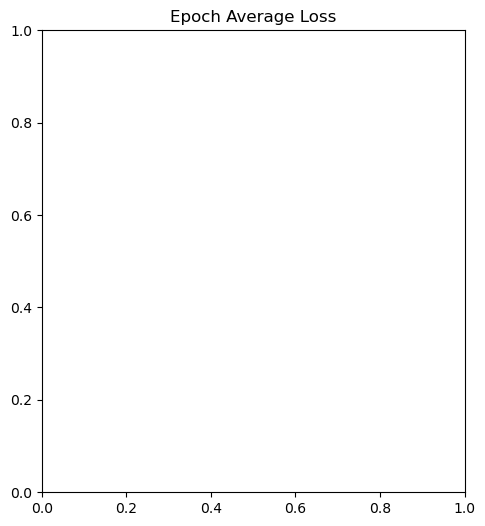

In [26]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

## Inference on Test Set

In [ ]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)

In [ ]:
##MODEL TRIED

In [ ]:
# # Copyright (c) MONAI Consortium
# # Licensed under the Apache License, Version 2.0 (the "License");
# # you may not use this file except in compliance with the License.
# # You may obtain a copy of the License at
# #     http://www.apache.org/licenses/LICENSE-2.0
# # Unless required by applicable law or agreed to in writing, software
# # distributed under the License is distributed on an "AS IS" BASIS,
# # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# # See the License for the specific language governing permissions and
# # limitations under the License.

# from __future__ import annotations

# from collections.abc import Sequence

# import numpy as np
# import torch
# import torch.nn as nn

# from monai.networks.blocks.convolutions import Convolution
# from monai.networks.layers.factories import Act, Norm
# from monai.networks.layers.utils import get_act_layer, get_norm_layer


# class UnetResBlock(nn.Module):
#     def __init__(
#         self,
#         in_channels: int,
#         out_channels: int,
#         kernel_size: Sequence[int] | int,
#         stride: Sequence[int] | int,
#         norm_name: tuple | str,
#         act_name: tuple | str = ("leakyrelu", {"inplace": True, "negative_slope": 0.01}),
#         dropout: tuple | str | float | None = None,
#     ):
#         super().__init__()
#         self.conv1 = get_conv_layer(
#             2,  # Using 2D convolutions
#             in_channels,
#             out_channels,
#             kernel_size=kernel_size,
#             stride=stride,
#             dropout=dropout,
#             act=None,
#             norm=None,
#             conv_only=False,
#         )
#         self.conv2 = get_conv_layer(
#             2,  # Using 2D convolutions
#             out_channels,
#             out_channels,
#             kernel_size=kernel_size,
#             stride=1,
#             dropout=dropout,
#             act=None,
#             norm=None,
#             conv_only=False,
#         )
#         self.lrelu = get_act_layer(name=act_name)
#         self.norm1 = get_norm_layer(name=norm_name, spatial_dims=2, channels=out_channels)
#         self.norm2 = get_norm_layer(name=norm_name, spatial_dims=2, channels=out_channels)
#         self.downsample = in_channels != out_channels
#         stride_np = np.atleast_1d(stride)
#         if not np.all(stride_np == 1):
#             self.downsample = True
#         if self.downsample:
#             self.conv3 = get_conv_layer(
#                 2,  # Using 2D convolutions
#                 in_channels,
#                 out_channels,
#                 kernel_size=1,
#                 stride=stride,
#                 dropout=dropout,
#                 act=None,
#                 norm=None,
#                 conv_only=False,
#             )
#             self.norm3 = get_norm_layer(name=norm_name, spatial_dims=2, channels=out_channels)

#     def forward(self, inp):
#         residual = inp
#         out = self.conv1(inp)
#         out = self.norm1(out)
#         out = self.lrelu(out)
#         out = self.conv2(out)
#         out = self.norm2(out)
#         if hasattr(self, "conv3"):
#             residual = self.conv3(residual)
#         if hasattr(self, "norm3"):
#             residual = self.norm3(residual)
#         out += residual
#         out = self.lrelu(out)
#         return out


# class UnetBasicBlock(nn.Module):
#     def __init__(
#         self,
#         in_channels: int,
#         out_channels: int,
#         kernel_size: Sequence[int] | int,
#         stride: Sequence[int] | int,
#         norm_name: tuple | str,
#         act_name: tuple | str = ("leakyrelu", {"inplace": True, "negative_slope": 0.01}),
#         dropout: tuple | str | float | None = None,
#     ):
#         super().__init__()
#         self.conv1 = get_conv_layer(
#             2,  # Using 2D convolutions
#             in_channels,
#             out_channels,
#             kernel_size=kernel_size,
#             stride=stride,
#             dropout=dropout,
#             act=None,
#             norm=None,
#             conv_only=False,
#         )
#         self.conv2 = get_conv_layer(
#             2,  # Using 2D convolutions
#             out_channels,
#             out_channels,
#             kernel_size=kernel_size,
#             stride=1,
#             dropout=dropout,
#             act=None,
#             norm=None,
#             conv_only=False,
#         )
#         self.lrelu = get_act_layer(name=act_name)
#         self.norm1 = get_norm_layer(name=norm_name, spatial_dims=2, channels=out_channels)
#         self.norm2 = get_norm_layer(name=norm_name, spatial_dims=2, channels=out_channels)

#     def forward(self, inp):
#         out = self.conv1(inp)
#         out = self.norm1(out)
#         out = self.lrelu(out)
#         out = self.conv2(out)
#         out = self.norm2(out)
#         out = self.lrelu(out)
#         return out


# class UnetUpBlock(nn.Module):
#     def __init__(
#         self,
#         in_channels: int,
#         out_channels: int,
#         kernel_size: Sequence[int] | int,
#         stride: Sequence[int] | int,
#         upsample_kernel_size: Sequence[int] | int,
#         norm_name: tuple | str,
#         act_name: tuple | str = ("leakyrelu", {"inplace": True, "negative_slope": 0.01}),
#         dropout: tuple | str | float | None = None,
#         trans_bias: bool = False,
#     ):
#         super().__init__()
#         upsample_stride = upsample_kernel_size
#         self.transp_conv = get_conv_layer(
#             2,  # Using 2D convolutions
#             in_channels,
#             out_channels,
#             kernel_size=upsample_kernel_size,
#             stride=upsample_stride,
#             dropout=dropout,
#             bias=trans_bias,
#             act=None,
#             norm=None,
#             conv_only=False,
#             is_transposed=True,
#         )
#         self.conv_block = UnetBasicBlock(
#             out_channels + out_channels,
#             out_channels,
#             kernel_size=kernel_size,
#             stride=1,
#             dropout=dropout,
#             norm_name=norm_name,
#             act_name=act_name,
#         )

#     def forward(self, inp, skip):
#         out = self.transp_conv(inp)
#         out = torch.cat((out, skip), dim=1)
#         out = self.conv_block(out)
#         return out


# class UnetOutBlock(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int, dropout: tuple | str | float | None = None):
#         super().__init__()
#         self.conv = get_conv_layer(
#             2,  # Using 2D convolutions
#             in_channels,
#             out_channels,
#             kernel_size=1,
#             stride=1,
#             dropout=dropout,
#             bias=True,
#             act=None,
#             norm=None,
#             conv_only=False,
#         )

#     def forward(self, inp):
#         return self.conv(inp)


# def get_conv_layer(
#     spatial_dims: int,
#     in_channels: int,
#     out_channels: int,
#     kernel_size: Sequence[int] | int = 3,
#     stride: Sequence[int] | int = 1,
#     act: tuple | str | None = Act.PRELU,
#     norm: tuple | str | None = Norm.INSTANCE,
#     dropout: tuple | str | float | None = None,
#     bias: bool = False,
#     conv_only: bool = True,
#     is_transposed: bool = False,
# ):
#     padding = get_padding(kernel_size, stride)
#     output_padding = None
#     if is_transposed:
#         output_padding = get_output_padding(kernel_size, stride, padding)
#     return Convolution(
#         spatial_dims,
#         in_channels,
#         out_channels,
#         strides=stride,
#         kernel_size=kernel_size,
#         act=act,
#         norm=norm,
#         dropout=dropout,
#         bias=bias,
#         conv_only=conv_only,
#         is_transposed=is_transposed,
#         padding=padding,
#         output_padding=output_padding,
#     )


# def get_padding(kernel_size: Sequence[int] | int, stride: Sequence[int] | int) -> tuple[int, ...] | int:
#     kernel_size_np = np.atleast_1d(kernel_size)
#     stride_np = np.atleast_1d(stride)
#     padding_np = (kernel_size_np - stride_np + 1) / 2
#     if np.min(padding_np) < 0:
#         raise AssertionError("padding value should not be negative, please change the kernel size and/or stride.")
#     padding = tuple(int(p) for p in padding_np)

#     return padding if len(padding) > 1 else padding[0]


# def get_output_padding(kernel_size: Sequence[int] | int, stride: Sequence[int] | int, padding: Sequence[int] | int) -> tuple[int, ...] | int:
#     kernel_size_np = np.atleast_1d(kernel_size)
#     stride_np = np.atleast_1d(stride)
#     padding_np = np.atleast_1d(padding)

#     out_padding_np = 2 * padding_np + stride_np - kernel_size_np
#     if np.min(out_padding_np) < 0:
#         raise AssertionError("out_padding value should not be negative, please change the kernel size and/or stride.")
#     out_padding = tuple(int(p) for p in out_padding_np)

#     return out_padding if len(out_padding) > 1 else out_padding[0]

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# import gc
# import os
# device = "cpu"
# # Assuming the rest of your model and dataset setup is already done

# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss_function = nn.CrossEntropyLoss()
# max_epochs = 10
# epoch_loss_values = []
# metric_values = []
# best_metric = -1
# best_metric_epoch = -1
# val_interval = 1  # Validate every epoch
# print("working")
# for epoch in range(max_epochs):
#     print("-" * 10)
#     print(f"epoch {epoch + 1}/{max_epochs}")
#     model.train()
#     epoch_loss = 0
#     step = 0

#     # Wrap the train_loader with tqdm for progress bar
#     for batch_data in tqdm(train_loader, desc="Training", leave=False):
#         print("in for loop")
#         step += 1
#         inputs, labels = (
#             batch_data["image"].to(device),
#             batch_data["label"].to(device),
#         )
#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = loss_function(outputs, labels)

#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         tqdm.write(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

#         # Free up memory
#         del inputs, labels, outputs, loss
#         torch.cuda.empty_cache()
#         gc.collect()

#     epoch_loss /= step
#     epoch_loss_values.append(epoch_loss)
#     print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         with torch.no_grad():
#             for val_data in tqdm(val_loader, desc="Validation", leave=False):
#                 val_inputs, val_labels = (
#                     val_data["image"].to(device),
#                     val_data["label"].to(device),
#                 )
#                 roi_size = (32, 32, 32)  # Further reduced size to reduce memory usage
#                 sw_batch_size = 1  # Sliding window batch size set to 1
#                 val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
#                 val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
#                 val_labels = [post_label(i) for i in decollate_batch(val_labels)]
#                 # compute metric for current iteration
#                 dice_metric(y_pred=val_outputs, y=val_labels)

#                 # Free up memory
#                 del val_inputs, val_labels, val_outputs
#                 torch.cuda.empty_cache()
#                 gc.collect()

#             # aggregate the final mean dice result
#             metric = dice_metric.aggregate().item()
#             # reset the status for next validation round
#             dice_metric.reset()

#             metric_values.append(metric)
#             if metric > best_metric:
#                 best_metric = metric
#                 best_metric_epoch = epoch + 1
#                 torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
#                 print("saved new best metric model")
#             print(
#                 f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
#                 f"\nbest mean dice: {best_metric:.4f} "
#                 f"at epoch: {best_metric_epoch}"
#             )

#     # Free up memory after each epoch
#     torch.cuda.empty_cache()
#     gc.collect()

# print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


In [ ]:
# import torch
# import torch.nn as nn
# from monai.networks.blocks.convolutions import Convolution
# from monai.networks.layers.factories import Act, Norm

# class UnetResBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, norm_name='batch', act_name='relu'):
#         super().__init__()
#         self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1)
#         self.norm1 = nn.BatchNorm3d(out_channels)
#         self.act1 = nn.ReLU(inplace=True)
        
#         self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1)
#         self.norm2 = nn.BatchNorm3d(out_channels)
#         self.act2 = nn.ReLU(inplace=True)
        
#         self.residual = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride)

#     def forward(self, x):
#         identity = self.residual(x)
#         out = self.act1(self.norm1(self.conv1(x)))
#         out = self.norm2(self.conv2(out))
#         out += identity
#         out = self.act2(out)
#         return out

# class UnetUpBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, norm_name='batch', act_name='relu'):
#         super().__init__()
#         self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
#         self.block = UnetResBlock(out_channels*2, out_channels, kernel_size, norm_name=norm_name, act_name=act_name)

#     def forward(self, x, skip):
#         x = self.upconv(x)
#         x = torch.cat((x, skip), dim=1)
#         x = self.block(x)
#         return x

# class UnetOutBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)

# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels, channels, strides, num_res_units, norm=Norm.BATCH):
#         super().__init__()
#         self.encoder = nn.ModuleList()
#         self.decoder = nn.ModuleList()

#         prev_channels = in_channels
#         for ch in channels:
#             self.encoder.append(UnetResBlock(prev_channels, ch, norm_name=norm))
#             prev_channels = ch

#         for i in range(len(channels)-1, 0, -1):
#             self.decoder.append(UnetUpBlock(channels[i], channels[i-1], norm_name=norm))

#         self.out_conv = UnetOutBlock(channels[0], out_channels)

#     def forward(self, x):
#         enc_outs = []
#         for enc in self.encoder:
#             x = enc(x)
#             enc_outs.append(x)

#         enc_outs = enc_outs[:-1][::-1]
#         for dec, skip in zip(self.decoder, enc_outs):
#             x = dec(x, skip)

#         x = self.out_conv(x)
#         return x

# # Set the device to MPS if available, otherwise fall back to CPU
# device = torch.device("cpu") if torch.has_mps else torch.device("cpu")

# model = UNet(
#     in_channels=1,
#     out_channels=2,
#     channels=(8, 16, 32, 64, 128),  # Use fewer channels
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)

# print(model)

# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
# optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# dice_metric = DiceMetric(include_background=False, reduction="mean")